In [1]:
import logging
import torch
logger = logging.getLogger()
fhandler = logging.FileHandler(filename='CNN_model1_on_A_new.log', mode='a')
logger.addHandler(fhandler)

In [3]:
import torch.nn as nn
from torch.nn import CrossEntropyLoss
import torch
import torchvision
from torch.optim import Adam
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor
from torch.utils.data import random_split, DataLoader
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
train_path = "/home/kusum/Desktop/Dataset A/Train" 
test_path = "/home/kusum/Desktop/Dataset A/Test"

In [5]:
train_ds = ImageFolder(train_path, transform=torchvision.transforms.Compose([torchvision.transforms.ToTensor(),
                               torchvision.transforms.Resize((512,512))]))
test_ds = ImageFolder(test_path, transform=torchvision.transforms.Compose([torchvision.transforms.ToTensor(),
                               torchvision.transforms.Resize((512,512))]))

In [6]:
len_train = len(train_ds)
len_test = len(test_ds)
len_train, len_test

(3600, 1256)

In [7]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

In [8]:
device = get_default_device()
device

device(type='cuda')

In [9]:
class convnet(nn.Module):
    def __init__(self):
        super(convnet, self).__init__()
        #shape=20, 3, 512, 512
        self.conv1 = nn.Conv2d(3, 16, kernel_size=(1,1), stride=1, padding=1)
        #shape=20, 16, 512, 512
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d((2,2))
        self.norm1 = nn.BatchNorm2d(16)
        #shape=20, 16, 256, 256

        self.conv2 = nn.Conv2d(16, 32, kernel_size=(3,3), stride=1, padding=1)
        #shape=20, 32, 256, 256
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d((2,2))
        #shape=20, 32, 128, 128        
        
        self.conv3 = nn.Conv2d(32, 64, kernel_size=(3,3), stride=1, padding=1)
        #shape=20, 64, 128, 128
        self.relu3 = nn.ReLU()
        self.drop = nn.Dropout2d(p=0.2)
       
        
        self.fc1 = nn.Linear(in_features= 64*128*128, out_features=100)
        self.fc2 = nn.Linear(in_features= 100, out_features=2)
        
        
    def forward(self, input):
        output = self.conv1(input)
        output = self.relu1(output)
        output = self.pool1(output)
        output = self.norm1(output)
        
        output = self.conv2(output)
        output = self.relu2(output)
        output = self.pool2(output)
    
        output = self.conv3(output)
        output = self.relu3(output)
        output = self.drop(output)
        
      
        output = output.view(-1, 64*128*128)
        output = self.fc1(output)
        output = self.fc2(output)
       
        return output
        

In [10]:
torch.cuda.empty_cache()
model = convnet().to(device)
model

convnet(
  (conv1): Conv2d(3, 16, kernel_size=(1, 1), stride=(1, 1), padding=(1, 1))
  (relu1): ReLU()
  (pool1): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (norm1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2): ReLU()
  (pool2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu3): ReLU()
  (drop): Dropout2d(p=0.2, inplace=False)
  (fc1): Linear(in_features=1048576, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=2, bias=True)
)

In [11]:
loss_fn = CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr = 0.0003, weight_decay = 0.001)

In [12]:
batch_size = 32
train_dl = DataLoader(train_ds, batch_size=batch_size, pin_memory=True, shuffle=True)
test_dl = DataLoader(test_ds, batch_size=batch_size, pin_memory=True, shuffle=True)

In [13]:
from time import time 
from tqdm import tqdm 
Train_accuracy = []
Train_loss = []
Val_loss = []
Val_accuracy = []
best_loss = 0
for epoch in range(90):
    train_acc = 0
    start1 = time()
    
    # Train
    model.train()
    
    with tqdm(train_dl, unit="batch") as tepoch:
        for xtrain, ytrain in tepoch:
            optimizer.zero_grad()
            
            xtrain = xtrain.to(device)
            train_prob = model(xtrain)
            train_prob = train_prob.cpu()
            loss = loss_fn(train_prob, ytrain)
            loss.backward()
            optimizer.step()
            # training ends
            
            train_pred = torch.max(train_prob, 1).indices
            #Train_loss.append(loss.item())
            train_acc += int(torch.sum(train_pred == ytrain))
           
           
        Train_loss.append(loss.item())    
        ep_tr_acc = train_acc / len_train
        Train_accuracy.append(ep_tr_acc)
    end1 = time()   
    
    #Model test-
    start2 = time()
    model.eval()
    test_acc = 0
    with torch.no_grad():
        for xtest, ytest in test_dl:
            xtest = xtest.to(device)
            test_prob = model(xtest)
            test_prob = test_prob.cpu()
            
            test_loss = loss_fn(test_prob, ytest)
            #Val_loss.append(test_loss.item())
            test_pred = torch.max(test_prob,1).indices
            test_acc += int(torch.sum(test_pred == ytest))
        
            
        Val_loss.append(test_loss.item())   
        ep_test_acc = test_acc / len_test
        Val_accuracy.append(ep_test_acc)
  
    if(epoch % 8 == 0):
        torch.save(model.state_dict(), "Best_CNN_basic_model_A_new" + str(epoch))
        
    end2 = time()
    duration1 = (end1 - start1) / 60
    duration2 = (end2 - start2) / 60

    print(f"Epoch: {epoch}, Time for one epoch for training: {duration1} \n Train_Loss: {loss}, Train_accuracy: {ep_tr_acc} \n Test_loss:{test_loss}, Test_accuracy:{ep_test_acc}, Test_duration:{duration2}")
    logging.warning(f"Epoch: {epoch}\n Time for one epoch: {duration1} \n Train_Loss: {loss}, Train_accuracy: {ep_tr_acc},  Test_loss:{test_loss}, Test_accuracy:{ep_test_acc}, Test_duration:{duration2}")

100%|██████████| 113/113 [00:47<00:00,  2.37batch/s]


Epoch: 0, Time for one epoch for training: 0.7938153386116028 
 Train_Loss: 0.20993341505527496, Train_accuracy: 0.8844444444444445 
 Test_loss:0.10227353870868683, Test_accuracy:0.8598726114649682, Test_duration:0.2782459179560343


100%|██████████| 113/113 [00:45<00:00,  2.48batch/s]


Epoch: 1, Time for one epoch for training: 0.7595861117045085 
 Train_Loss: 0.03985337167978287, Train_accuracy: 0.9797222222222223 
 Test_loss:0.003386450931429863, Test_accuracy:0.8535031847133758, Test_duration:0.2693490425745646


100%|██████████| 113/113 [00:45<00:00,  2.47batch/s]


Epoch: 2, Time for one epoch for training: 0.7609926144282023 
 Train_Loss: 0.004163783509284258, Train_accuracy: 0.9886111111111111 
 Test_loss:0.715339720249176, Test_accuracy:0.820859872611465, Test_duration:0.27042073806126915


100%|██████████| 113/113 [00:45<00:00,  2.47batch/s]


Epoch: 3, Time for one epoch for training: 0.7628047704696655 
 Train_Loss: 0.015210006386041641, Train_accuracy: 0.9941666666666666 
 Test_loss:0.07200487703084946, Test_accuracy:0.8710191082802548, Test_duration:0.27318108081817627


100%|██████████| 113/113 [00:45<00:00,  2.46batch/s]


Epoch: 4, Time for one epoch for training: 0.7655363917350769 
 Train_Loss: 0.22764213383197784, Train_accuracy: 0.9927777777777778 
 Test_loss:1.1010067462921143, Test_accuracy:0.8861464968152867, Test_duration:0.2712287902832031


100%|██████████| 113/113 [00:45<00:00,  2.47batch/s]


Epoch: 5, Time for one epoch for training: 0.763764476776123 
 Train_Loss: 0.05133998394012451, Train_accuracy: 0.9933333333333333 
 Test_loss:0.37655678391456604, Test_accuracy:0.8678343949044586, Test_duration:0.2737334966659546


100%|██████████| 113/113 [00:46<00:00,  2.43batch/s]


Epoch: 6, Time for one epoch for training: 0.7738373438517253 
 Train_Loss: 0.1348946988582611, Train_accuracy: 0.9972222222222222 
 Test_loss:0.002619631588459015, Test_accuracy:0.8718152866242038, Test_duration:0.2765059550603231


100%|██████████| 113/113 [00:46<00:00,  2.42batch/s]


Epoch: 7, Time for one epoch for training: 0.7780995686848958 
 Train_Loss: 0.04522276297211647, Train_accuracy: 0.9877777777777778 
 Test_loss:0.008072009310126305, Test_accuracy:0.8773885350318471, Test_duration:0.27219243049621583


100%|██████████| 113/113 [00:46<00:00,  2.44batch/s]


Epoch: 8, Time for one epoch for training: 0.7729905207951864 
 Train_Loss: 0.0028807909693568945, Train_accuracy: 0.9969444444444444 
 Test_loss:0.07594526559114456, Test_accuracy:0.8495222929936306, Test_duration:0.2808007756868998


100%|██████████| 113/113 [00:46<00:00,  2.44batch/s]


Epoch: 9, Time for one epoch for training: 0.7708297451337178 
 Train_Loss: 0.010134869255125523, Train_accuracy: 0.9972222222222222 
 Test_loss:0.08828800916671753, Test_accuracy:0.839171974522293, Test_duration:0.27780750195185344


100%|██████████| 113/113 [00:47<00:00,  2.39batch/s]


Epoch: 10, Time for one epoch for training: 0.7872689247131348 
 Train_Loss: 0.0072426386177539825, Train_accuracy: 0.9869444444444444 
 Test_loss:0.46536996960639954, Test_accuracy:0.8789808917197452, Test_duration:0.2800224184989929


100%|██████████| 113/113 [00:46<00:00,  2.43batch/s]


Epoch: 11, Time for one epoch for training: 0.7763249198595683 
 Train_Loss: 0.0004955120966769755, Train_accuracy: 0.9925 
 Test_loss:1.3506689071655273, Test_accuracy:0.8375796178343949, Test_duration:0.27732100486755373


100%|██████████| 113/113 [00:47<00:00,  2.39batch/s]


Epoch: 12, Time for one epoch for training: 0.7865643978118897 
 Train_Loss: 0.0002983773301821202, Train_accuracy: 0.9977777777777778 
 Test_loss:1.1810836791992188, Test_accuracy:0.8630573248407644, Test_duration:0.2763251344362895


100%|██████████| 113/113 [00:46<00:00,  2.42batch/s]


Epoch: 13, Time for one epoch for training: 0.7782064914703369 
 Train_Loss: 0.0015195426531136036, Train_accuracy: 0.9983333333333333 
 Test_loss:0.5748159885406494, Test_accuracy:0.8248407643312102, Test_duration:0.2771661917368571


100%|██████████| 113/113 [00:46<00:00,  2.41batch/s]


Epoch: 14, Time for one epoch for training: 0.7802249948183696 
 Train_Loss: 0.011246731504797935, Train_accuracy: 0.9983333333333333 
 Test_loss:0.007942966185510159, Test_accuracy:0.8471337579617835, Test_duration:0.2838780124982198


100%|██████████| 113/113 [00:45<00:00,  2.46batch/s]


Epoch: 15, Time for one epoch for training: 0.765750785668691 
 Train_Loss: 0.044431429356336594, Train_accuracy: 0.9930555555555556 
 Test_loss:0.5625284314155579, Test_accuracy:0.7914012738853503, Test_duration:0.27968955834706627


100%|██████████| 113/113 [00:45<00:00,  2.46batch/s]


Epoch: 16, Time for one epoch for training: 0.7649893283843994 
 Train_Loss: 0.0416087806224823, Train_accuracy: 0.9847222222222223 
 Test_loss:1.0331472158432007, Test_accuracy:0.8590764331210191, Test_duration:0.280877947807312


100%|██████████| 113/113 [00:46<00:00,  2.42batch/s]


Epoch: 17, Time for one epoch for training: 0.7793413996696472 
 Train_Loss: 0.021364567801356316, Train_accuracy: 0.9925 
 Test_loss:0.7408655881881714, Test_accuracy:0.8367834394904459, Test_duration:0.27695343891779584


100%|██████████| 113/113 [00:46<00:00,  2.42batch/s]


Epoch: 18, Time for one epoch for training: 0.7768498500188191 
 Train_Loss: 0.00022581535449717194, Train_accuracy: 0.9972222222222222 
 Test_loss:0.0065778037533164024, Test_accuracy:0.8487261146496815, Test_duration:0.27553358872731526


100%|██████████| 113/113 [00:47<00:00,  2.39batch/s]


Epoch: 19, Time for one epoch for training: 0.7869768699010213 
 Train_Loss: 0.00011909104796359316, Train_accuracy: 0.9911111111111112 
 Test_loss:1.4597041606903076, Test_accuracy:0.8511146496815286, Test_duration:0.2861008246739705


100%|██████████| 113/113 [00:47<00:00,  2.38batch/s]


Epoch: 20, Time for one epoch for training: 0.7910571535428365 
 Train_Loss: 0.002395189367234707, Train_accuracy: 0.9991666666666666 
 Test_loss:1.490556240081787, Test_accuracy:0.8550955414012739, Test_duration:0.2854835271835327


100%|██████████| 113/113 [00:47<00:00,  2.37batch/s]


Epoch: 21, Time for one epoch for training: 0.7944920937220256 
 Train_Loss: 0.001717400853522122, Train_accuracy: 0.9966666666666667 
 Test_loss:0.0019732320215553045, Test_accuracy:0.8407643312101911, Test_duration:0.2774966279665629


100%|██████████| 113/113 [00:46<00:00,  2.43batch/s]


Epoch: 22, Time for one epoch for training: 0.7761978507041931 
 Train_Loss: 0.035396598279476166, Train_accuracy: 0.995 
 Test_loss:0.4314265251159668, Test_accuracy:0.8670382165605095, Test_duration:0.2833967129389445


100%|██████████| 113/113 [00:47<00:00,  2.39batch/s]


Epoch: 23, Time for one epoch for training: 0.7894807895024617 
 Train_Loss: 0.0007776690181344748, Train_accuracy: 0.9863888888888889 
 Test_loss:0.14363840222358704, Test_accuracy:0.8503184713375797, Test_duration:0.2803481658299764


100%|██████████| 113/113 [00:47<00:00,  2.40batch/s]


Epoch: 24, Time for one epoch for training: 0.7863242626190186 
 Train_Loss: 0.0002406213607173413, Train_accuracy: 0.9936111111111111 
 Test_loss:1.073525309562683, Test_accuracy:0.8328025477707006, Test_duration:0.29120424191157024


100%|██████████| 113/113 [00:47<00:00,  2.37batch/s]


Epoch: 25, Time for one epoch for training: 0.7946914235750834 
 Train_Loss: 0.0006325219292193651, Train_accuracy: 0.9922222222222222 
 Test_loss:3.6417999267578125, Test_accuracy:0.8328025477707006, Test_duration:0.27666606108347574


100%|██████████| 113/113 [00:47<00:00,  2.40batch/s]


Epoch: 26, Time for one epoch for training: 0.7838933070500692 
 Train_Loss: 0.0010749984066933393, Train_accuracy: 0.9969444444444444 
 Test_loss:0.6267518401145935, Test_accuracy:0.8296178343949044, Test_duration:0.2773699363072713


100%|██████████| 113/113 [00:47<00:00,  2.40batch/s]


Epoch: 27, Time for one epoch for training: 0.7857402563095093 
 Train_Loss: 0.0009795736987143755, Train_accuracy: 0.9975 
 Test_loss:0.00023268474615179002, Test_accuracy:0.8328025477707006, Test_duration:0.2781510233879089


100%|██████████| 113/113 [00:46<00:00,  2.41batch/s]


Epoch: 28, Time for one epoch for training: 0.7807625611623128 
 Train_Loss: 0.02545093558728695, Train_accuracy: 0.9913888888888889 
 Test_loss:1.7667021751403809, Test_accuracy:0.785031847133758, Test_duration:0.2780258933703105


100%|██████████| 113/113 [00:46<00:00,  2.43batch/s]


Epoch: 29, Time for one epoch for training: 0.7736607948939006 
 Train_Loss: 0.0047551728785037994, Train_accuracy: 0.9925 
 Test_loss:0.42430436611175537, Test_accuracy:0.8264331210191083, Test_duration:0.27580513159434


100%|██████████| 113/113 [00:46<00:00,  2.41batch/s]


Epoch: 30, Time for one epoch for training: 0.7829653700192769 
 Train_Loss: 0.0007126019336283207, Train_accuracy: 0.995 
 Test_loss:1.6110610961914062, Test_accuracy:0.8351910828025477, Test_duration:0.2764255444208781


100%|██████████| 113/113 [00:46<00:00,  2.44batch/s]


Epoch: 31, Time for one epoch for training: 0.7733645598093669 
 Train_Loss: 0.04364980012178421, Train_accuracy: 0.9961111111111111 
 Test_loss:0.42800167202949524, Test_accuracy:0.8853503184713376, Test_duration:0.284005876382192


100%|██████████| 113/113 [00:46<00:00,  2.42batch/s]


Epoch: 32, Time for one epoch for training: 0.7771840333938599 
 Train_Loss: 0.006901720073074102, Train_accuracy: 0.9944444444444445 
 Test_loss:0.7739962935447693, Test_accuracy:0.8168789808917197, Test_duration:0.2822679122289022


100%|██████████| 113/113 [00:47<00:00,  2.40batch/s]


Epoch: 33, Time for one epoch for training: 0.783390200138092 
 Train_Loss: 0.0021919170394539833, Train_accuracy: 0.9975 
 Test_loss:0.0002530879864934832, Test_accuracy:0.8439490445859873, Test_duration:0.2771839380264282


100%|██████████| 113/113 [00:46<00:00,  2.40batch/s]


Epoch: 34, Time for one epoch for training: 0.783276359240214 
 Train_Loss: 0.02961854264140129, Train_accuracy: 0.9958333333333333 
 Test_loss:1.2170674800872803, Test_accuracy:0.8057324840764332, Test_duration:0.27410443623860675


100%|██████████| 113/113 [00:46<00:00,  2.42batch/s]


Epoch: 35, Time for one epoch for training: 0.7798256993293762 
 Train_Loss: 0.049714673310518265, Train_accuracy: 0.9911111111111112 
 Test_loss:1.1799428462982178, Test_accuracy:0.8519108280254777, Test_duration:0.27901552120844525


100%|██████████| 113/113 [00:46<00:00,  2.42batch/s]


Epoch: 36, Time for one epoch for training: 0.7797901431719462 
 Train_Loss: 0.05810808017849922, Train_accuracy: 0.9958333333333333 
 Test_loss:6.81575870513916, Test_accuracy:0.8447452229299363, Test_duration:0.2794324517250061


100%|██████████| 113/113 [00:46<00:00,  2.41batch/s]


Epoch: 37, Time for one epoch for training: 0.780632225672404 
 Train_Loss: 1.8737331629381515e-05, Train_accuracy: 0.9933333333333333 
 Test_loss:2.257542610168457, Test_accuracy:0.8105095541401274, Test_duration:0.28700138727823893


100%|██████████| 113/113 [00:45<00:00,  2.46batch/s]


Epoch: 38, Time for one epoch for training: 0.7661535739898682 
 Train_Loss: 0.002921626204624772, Train_accuracy: 0.9972222222222222 
 Test_loss:1.6161532402038574, Test_accuracy:0.8471337579617835, Test_duration:0.2719402511914571


100%|██████████| 113/113 [00:46<00:00,  2.41batch/s]


Epoch: 39, Time for one epoch for training: 0.7812946438789368 
 Train_Loss: 0.0007520945509895682, Train_accuracy: 0.9994444444444445 
 Test_loss:0.3339202404022217, Test_accuracy:0.8455414012738853, Test_duration:0.2770702759424845


100%|██████████| 113/113 [00:46<00:00,  2.45batch/s]


Epoch: 40, Time for one epoch for training: 0.7682313879330953 
 Train_Loss: 0.0029403178486973047, Train_accuracy: 0.9975 
 Test_loss:0.02598295547068119, Test_accuracy:0.8718152866242038, Test_duration:0.28438425858815514


100%|██████████| 113/113 [00:46<00:00,  2.42batch/s]


Epoch: 41, Time for one epoch for training: 0.7779725432395935 
 Train_Loss: 0.0002971053181681782, Train_accuracy: 0.9966666666666667 
 Test_loss:1.6799721717834473, Test_accuracy:0.8487261146496815, Test_duration:0.28455952405929563


100%|██████████| 113/113 [00:47<00:00,  2.39batch/s]


Epoch: 42, Time for one epoch for training: 0.7884582241376241 
 Train_Loss: 0.04661639779806137, Train_accuracy: 0.9966666666666667 
 Test_loss:4.75506067276001, Test_accuracy:0.8503184713375797, Test_duration:0.2741437037785848


100%|██████████| 113/113 [00:46<00:00,  2.43batch/s]


Epoch: 43, Time for one epoch for training: 0.775688381989797 
 Train_Loss: 0.08132392913103104, Train_accuracy: 0.9933333333333333 
 Test_loss:1.8284753561019897, Test_accuracy:0.8527070063694268, Test_duration:0.28447152773539225


100%|██████████| 113/113 [00:46<00:00,  2.42batch/s]


Epoch: 44, Time for one epoch for training: 0.7782993634541829 
 Train_Loss: 2.900211256928742e-05, Train_accuracy: 0.9961111111111111 
 Test_loss:0.09587457776069641, Test_accuracy:0.8359872611464968, Test_duration:0.277522075176239


100%|██████████| 113/113 [00:47<00:00,  2.39batch/s]


Epoch: 45, Time for one epoch for training: 0.7870763699213664 
 Train_Loss: 0.00033384724520146847, Train_accuracy: 0.9975 
 Test_loss:0.019968658685684204, Test_accuracy:0.8662420382165605, Test_duration:0.2838313579559326


100%|██████████| 113/113 [00:46<00:00,  2.42batch/s]


Epoch: 46, Time for one epoch for training: 0.7790002822875977 
 Train_Loss: 0.0002695535367820412, Train_accuracy: 0.9991666666666666 
 Test_loss:0.20149721205234528, Test_accuracy:0.8407643312101911, Test_duration:0.28651502132415774


100%|██████████| 113/113 [00:46<00:00,  2.44batch/s]


Epoch: 47, Time for one epoch for training: 0.7720108747482299 
 Train_Loss: 0.0038568959571421146, Train_accuracy: 0.9975 
 Test_loss:5.564769268035889, Test_accuracy:0.804140127388535, Test_duration:0.2802020788192749


100%|██████████| 113/113 [00:47<00:00,  2.40batch/s]


Epoch: 48, Time for one epoch for training: 0.7850112199783326 
 Train_Loss: 0.009252804331481457, Train_accuracy: 0.9983333333333333 
 Test_loss:0.695884644985199, Test_accuracy:0.822452229299363, Test_duration:0.2947880466779073


100%|██████████| 113/113 [00:47<00:00,  2.39batch/s]


Epoch: 49, Time for one epoch for training: 0.7878392338752747 
 Train_Loss: 0.010591529309749603, Train_accuracy: 0.9988888888888889 
 Test_loss:0.20181064307689667, Test_accuracy:0.839968152866242, Test_duration:0.2843337814013163


100%|██████████| 113/113 [00:46<00:00,  2.45batch/s]


Epoch: 50, Time for one epoch for training: 0.7684909343719483 
 Train_Loss: 0.038511693477630615, Train_accuracy: 0.9936111111111111 
 Test_loss:0.22951172292232513, Test_accuracy:0.821656050955414, Test_duration:0.28098495801289874


100%|██████████| 113/113 [00:46<00:00,  2.45batch/s]


Epoch: 51, Time for one epoch for training: 0.7695081075032552 
 Train_Loss: 0.029866190627217293, Train_accuracy: 0.995 
 Test_loss:1.557521104812622, Test_accuracy:0.8367834394904459, Test_duration:0.27404510180155434


100%|██████████| 113/113 [00:46<00:00,  2.45batch/s]


Epoch: 52, Time for one epoch for training: 0.768822459379832 
 Train_Loss: 0.042615268379449844, Train_accuracy: 0.9961111111111111 
 Test_loss:0.017352068796753883, Test_accuracy:0.8734076433121019, Test_duration:0.27219599882761636


100%|██████████| 113/113 [00:46<00:00,  2.43batch/s]


Epoch: 53, Time for one epoch for training: 0.7749361236890157 
 Train_Loss: 0.0005048439488746226, Train_accuracy: 0.9941666666666666 
 Test_loss:1.0834789276123047, Test_accuracy:0.8383757961783439, Test_duration:0.27184486786524453


100%|██████████| 113/113 [00:46<00:00,  2.44batch/s]


Epoch: 54, Time for one epoch for training: 0.7716986258824666 
 Train_Loss: 0.0008790220017544925, Train_accuracy: 0.9972222222222222 
 Test_loss:0.17469173669815063, Test_accuracy:0.8694267515923567, Test_duration:0.2808771769205729


100%|██████████| 113/113 [00:46<00:00,  2.43batch/s]


Epoch: 55, Time for one epoch for training: 0.7743722120920817 
 Train_Loss: 0.0019929795525968075, Train_accuracy: 0.9986111111111111 
 Test_loss:0.037703197449445724, Test_accuracy:0.85828025477707, Test_duration:0.2707619309425354


100%|██████████| 113/113 [00:47<00:00,  2.39batch/s]


Epoch: 56, Time for one epoch for training: 0.7890377918879191 
 Train_Loss: 0.0003549639950506389, Train_accuracy: 0.9994444444444445 
 Test_loss:2.7911670207977295, Test_accuracy:0.8383757961783439, Test_duration:0.2872169812520345


100%|██████████| 113/113 [00:46<00:00,  2.43batch/s]


Epoch: 57, Time for one epoch for training: 0.7739245136578877 
 Train_Loss: 0.00017258338630199432, Train_accuracy: 0.9994444444444445 
 Test_loss:1.5377756357192993, Test_accuracy:0.8328025477707006, Test_duration:0.27855960925420126


100%|██████████| 113/113 [00:45<00:00,  2.47batch/s]


Epoch: 58, Time for one epoch for training: 0.7611856857935587 
 Train_Loss: 0.00120372767560184, Train_accuracy: 0.9991666666666666 
 Test_loss:1.968637466430664, Test_accuracy:0.8001592356687898, Test_duration:0.2775205890337626


100%|██████████| 113/113 [00:45<00:00,  2.46batch/s]


Epoch: 59, Time for one epoch for training: 0.7647684057553609 
 Train_Loss: 0.00037353707011789083, Train_accuracy: 0.9986111111111111 
 Test_loss:1.2352381944656372, Test_accuracy:0.8646496815286624, Test_duration:0.27742223342259725


100%|██████████| 113/113 [00:46<00:00,  2.43batch/s]


Epoch: 60, Time for one epoch for training: 0.7764594276746114 
 Train_Loss: 0.001782747684046626, Train_accuracy: 0.9986111111111111 
 Test_loss:0.3315619230270386, Test_accuracy:0.8375796178343949, Test_duration:0.27919089794158936


100%|██████████| 113/113 [00:46<00:00,  2.44batch/s]


Epoch: 61, Time for one epoch for training: 0.7713305354118347 
 Train_Loss: 0.10162870585918427, Train_accuracy: 0.9988888888888889 
 Test_loss:1.4280931949615479, Test_accuracy:0.7961783439490446, Test_duration:0.27026650110880535


100%|██████████| 113/113 [00:46<00:00,  2.44batch/s]


Epoch: 62, Time for one epoch for training: 0.7711056550343831 
 Train_Loss: 0.09019076079130173, Train_accuracy: 0.9941666666666666 
 Test_loss:3.6944351196289062, Test_accuracy:0.802547770700637, Test_duration:0.2767259836196899


100%|██████████| 113/113 [00:45<00:00,  2.47batch/s]


Epoch: 63, Time for one epoch for training: 0.7631513396898906 
 Train_Loss: 0.059721626341342926, Train_accuracy: 0.9977777777777778 
 Test_loss:0.7603198289871216, Test_accuracy:0.8192675159235668, Test_duration:0.27622643709182737


100%|██████████| 113/113 [00:47<00:00,  2.40batch/s]


Epoch: 64, Time for one epoch for training: 0.7860739270846049 
 Train_Loss: 0.01884966529905796, Train_accuracy: 0.9963888888888889 
 Test_loss:0.8170681595802307, Test_accuracy:0.8335987261146497, Test_duration:0.2782809098561605


100%|██████████| 113/113 [00:46<00:00,  2.45batch/s]


Epoch: 65, Time for one epoch for training: 0.7676230589548747 
 Train_Loss: 0.002879895269870758, Train_accuracy: 0.9991666666666666 
 Test_loss:0.34406134486198425, Test_accuracy:0.8351910828025477, Test_duration:0.2790743192036947


100%|██████████| 113/113 [00:47<00:00,  2.40batch/s]


Epoch: 66, Time for one epoch for training: 0.7850030899047852 
 Train_Loss: 0.0006123409839347005, Train_accuracy: 0.9977777777777778 
 Test_loss:2.1061577796936035, Test_accuracy:0.8296178343949044, Test_duration:0.27468146085739137


100%|██████████| 113/113 [00:46<00:00,  2.45batch/s]


Epoch: 67, Time for one epoch for training: 0.7702008366584778 
 Train_Loss: 0.0033362507820129395, Train_accuracy: 0.9983333333333333 
 Test_loss:0.0644751712679863, Test_accuracy:0.8367834394904459, Test_duration:0.2719144105911255


100%|██████████| 113/113 [00:46<00:00,  2.43batch/s]


Epoch: 68, Time for one epoch for training: 0.7745231986045837 
 Train_Loss: 0.001221553422510624, Train_accuracy: 0.9969444444444444 
 Test_loss:2.033053159713745, Test_accuracy:0.8256369426751592, Test_duration:0.26978835264841716


100%|██████████| 113/113 [00:45<00:00,  2.46batch/s]


Epoch: 69, Time for one epoch for training: 0.7661871631940206 
 Train_Loss: 1.4072794328967575e-05, Train_accuracy: 0.9986111111111111 
 Test_loss:1.044878363609314, Test_accuracy:0.8240445859872612, Test_duration:0.2726923187573751


100%|██████████| 113/113 [00:47<00:00,  2.40batch/s]


Epoch: 70, Time for one epoch for training: 0.7834945162137349 
 Train_Loss: 0.00017966506129596382, Train_accuracy: 0.9994444444444445 
 Test_loss:1.491760015487671, Test_accuracy:0.8535031847133758, Test_duration:0.2738436579704285


100%|██████████| 113/113 [00:45<00:00,  2.46batch/s]


Epoch: 71, Time for one epoch for training: 0.7665461500485738 
 Train_Loss: 0.00023048858565744013, Train_accuracy: 0.9991666666666666 
 Test_loss:1.1417803764343262, Test_accuracy:0.839171974522293, Test_duration:0.2747135003407796


100%|██████████| 113/113 [00:45<00:00,  2.48batch/s]


Epoch: 72, Time for one epoch for training: 0.7587880253791809 
 Train_Loss: 1.291837907047011e-05, Train_accuracy: 0.9988888888888889 
 Test_loss:1.7587722539901733, Test_accuracy:0.8184713375796179, Test_duration:0.2759564797083537


100%|██████████| 113/113 [00:46<00:00,  2.42batch/s]


Epoch: 73, Time for one epoch for training: 0.7769346435864767 
 Train_Loss: 0.01950978673994541, Train_accuracy: 0.9977777777777778 
 Test_loss:0.007449558936059475, Test_accuracy:0.8288216560509554, Test_duration:0.27150169213612874


100%|██████████| 113/113 [00:46<00:00,  2.45batch/s]


Epoch: 74, Time for one epoch for training: 0.7673365672429403 
 Train_Loss: 0.002512700390070677, Train_accuracy: 0.9969444444444444 
 Test_loss:2.3827898502349854, Test_accuracy:0.8049363057324841, Test_duration:0.27256571849187217


100%|██████████| 113/113 [00:47<00:00,  2.40batch/s]


Epoch: 75, Time for one epoch for training: 0.7844536622365316 
 Train_Loss: 0.05079267546534538, Train_accuracy: 0.9966666666666667 
 Test_loss:0.06572843343019485, Test_accuracy:0.8081210191082803, Test_duration:0.2735150615374247


100%|██████████| 113/113 [00:46<00:00,  2.43batch/s]


Epoch: 76, Time for one epoch for training: 0.7739279468854269 
 Train_Loss: 1.1525510672072414e-05, Train_accuracy: 0.9977777777777778 
 Test_loss:0.48273399472236633, Test_accuracy:0.8256369426751592, Test_duration:0.27274396022160846


100%|██████████| 113/113 [00:46<00:00,  2.43batch/s]


Epoch: 77, Time for one epoch for training: 0.7737699151039124 
 Train_Loss: 0.0006534117856062949, Train_accuracy: 0.9994444444444445 
 Test_loss:2.758446216583252, Test_accuracy:0.8248407643312102, Test_duration:0.2778168876965841


100%|██████████| 113/113 [00:46<00:00,  2.45batch/s]


Epoch: 78, Time for one epoch for training: 0.767715326944987 
 Train_Loss: 0.006335735786706209, Train_accuracy: 0.9983333333333333 
 Test_loss:0.951188862323761, Test_accuracy:0.8240445859872612, Test_duration:0.2711189270019531


100%|██████████| 113/113 [00:46<00:00,  2.44batch/s]


Epoch: 79, Time for one epoch for training: 0.7722369829813639 
 Train_Loss: 0.00015353063645306975, Train_accuracy: 0.9977777777777778 
 Test_loss:0.4227166175842285, Test_accuracy:0.822452229299363, Test_duration:0.2699743827184041


100%|██████████| 113/113 [00:46<00:00,  2.44batch/s]


Epoch: 80, Time for one epoch for training: 0.7710564374923706 
 Train_Loss: 0.0002869842282962054, Train_accuracy: 0.9994444444444445 
 Test_loss:0.2649221420288086, Test_accuracy:0.8606687898089171, Test_duration:0.28526031573613486


100%|██████████| 113/113 [00:45<00:00,  2.47batch/s]


Epoch: 81, Time for one epoch for training: 0.76214120388031 
 Train_Loss: 6.534177373396233e-05, Train_accuracy: 0.9991666666666666 
 Test_loss:1.4594179391860962, Test_accuracy:0.8264331210191083, Test_duration:0.2787167270978292


100%|██████████| 113/113 [00:45<00:00,  2.46batch/s]


Epoch: 82, Time for one epoch for training: 0.7656256000200907 
 Train_Loss: 7.748590178380255e-07, Train_accuracy: 0.9994444444444445 
 Test_loss:4.62972354888916, Test_accuracy:0.8590764331210191, Test_duration:0.27809463342030843


100%|██████████| 113/113 [00:47<00:00,  2.38batch/s]


Epoch: 83, Time for one epoch for training: 0.7903964718182882 
 Train_Loss: 2.458667950122617e-06, Train_accuracy: 1.0 
 Test_loss:0.003948662430047989, Test_accuracy:0.8431528662420382, Test_duration:0.2714155395825704


100%|██████████| 113/113 [00:45<00:00,  2.46batch/s]


Epoch: 84, Time for one epoch for training: 0.7647256692250569 
 Train_Loss: 0.0003265015548095107, Train_accuracy: 0.9997222222222222 
 Test_loss:3.1427838802337646, Test_accuracy:0.821656050955414, Test_duration:0.27686433792114257


100%|██████████| 113/113 [00:45<00:00,  2.46batch/s]


Epoch: 85, Time for one epoch for training: 0.7643602768580119 
 Train_Loss: 8.828353202261496e-06, Train_accuracy: 1.0 
 Test_loss:0.21517765522003174, Test_accuracy:0.8248407643312102, Test_duration:0.27645975748697915


100%|██████████| 113/113 [00:46<00:00,  2.45batch/s]


Epoch: 86, Time for one epoch for training: 0.7700988531112671 
 Train_Loss: 9.298129953094758e-06, Train_accuracy: 1.0 
 Test_loss:1.00852370262146, Test_accuracy:0.8328025477707006, Test_duration:0.28083778619766236


100%|██████████| 113/113 [00:45<00:00,  2.49batch/s]


Epoch: 87, Time for one epoch for training: 0.7574690103530883 
 Train_Loss: 0.0003484923217911273, Train_accuracy: 1.0 
 Test_loss:0.00033802303369157016, Test_accuracy:0.8598726114649682, Test_duration:0.2701112747192383


100%|██████████| 113/113 [00:46<00:00,  2.43batch/s]


Epoch: 88, Time for one epoch for training: 0.775050687789917 
 Train_Loss: 0.00038782236515544355, Train_accuracy: 0.9988888888888889 
 Test_loss:0.01904229447245598, Test_accuracy:0.8272292993630573, Test_duration:0.29184938271840416


100%|██████████| 113/113 [00:46<00:00,  2.44batch/s]


Epoch: 89, Time for one epoch for training: 0.7707169413566589 
 Train_Loss: 0.02409893088042736, Train_accuracy: 0.9969444444444444 
 Test_loss:3.820110321044922, Test_accuracy:0.856687898089172, Test_duration:0.27925699949264526


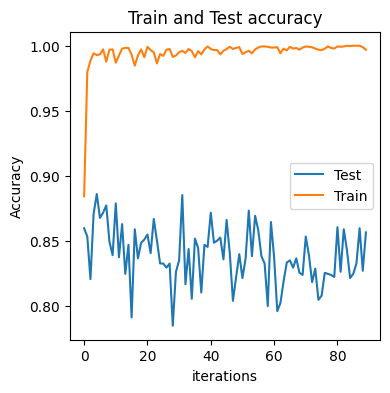

In [14]:
plt.figure(figsize=(4,4))
plt.title("Train and Test accuracy")
plt.plot(Val_accuracy,label="Test")
plt.plot(Train_accuracy,label="Train")
plt.xlabel("iterations")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

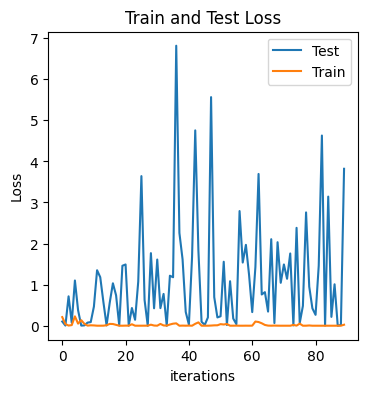

In [15]:
plt.figure(figsize=(4,4))
plt.title("Train and Test Loss")
plt.plot(Val_loss,label="Test")
plt.plot(Train_loss,label="Train")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()